In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


## Exercise - Classification

We're going to code a binary classifier for 2D input data. 

Consider the network shown in Figure 6.2 in Goodfellow. If we include all bias terms, this network will have 9 free parameters.

1. Derive the update rules (gradient) for each of the weights and biases for the network in Figure 6.2. Use sigmoid activation units (or ReLU units if you'd prefer). You can either derive each partial derivtive individually, or rely on the generic forumla we discussed.

2. Write a new function grad_f() for this kind of network.

3. Verify that you can fit the simple Gaussian dataset below, make a plot of the Loss throughout training. 

In [2]:

def loss(y, y_hat):
    # binary cross entropy
    return  np.sum(- (y*np.log(y_hat) + (1-y)*np.log(1 - y_hat)))

def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def relu(x):
    return np.maximum(x,0)

def relu_derivative(x):
    return np.where(x>0, 1, 0)

def yhat(x, W, b, v, c):
    # returns model prediction 
    h = relu(np.dot(x,W) + b) #activation function of hidden layer
    y = sigmoid(np.dot(h,v) + c) #output function (activation function on neurons of last layer)
    return y

def binary_xent_residual(y, y_hat): #derivative of Loss function over y_hat
    return (y/y_hat - (1-y)/(1-y_hat))

def pack_params(param_vec):
    w_11, w_12, w_21, w_22, b_1, b_2, v_1, v_2, c = param_vec
    W = np.array([[w_11,w_12],[w_21,w_22]])
    b = np.array([b_1, b_2])
    v = np.array([v_1,v_2])#weights of the output layer
    c = np.array([c])
    return((W, b, v, c)) 


In [3]:
W = np.random.randn(4).reshape((2,2)) #2x2 weights matrix from input to hidden input
b = np.random.randn(2) #2 biases for 2 hidden nodes
v = np.random.randn(2) #2 weights for the hidden output to output y_hat
c = np.random.randn(1) #2 biases for outputs

In [4]:
def grad_f(param_vec, x, y):
    
    W, b, v, c = pack_params(param_vec)
    
    a = np.dot(x,W)+b #linear input to the hidden layer
    h = relu(a) #non-linear output of hidden layer
    y_a = np.dot(h,v)+c #linear input to the output node
    y_hat = sigmoid(y_a) #squash it into probability (non-linear activation function of output layer)
    
    dL_dc = np.average(binary_xent_residual(y, y_hat) * sigmoid_derivative(y_a))
    
    dL_dv1 =  np.average(binary_xent_residual(y, y_hat) * sigmoid_derivative(y_a) * h[:,1])
    dL_dv2 =  np.average(binary_xent_residual(y, y_hat) * sigmoid_derivative(y_a) * h[:,0])
    
    dL_db1 =  np.average(binary_xent_residual(y, y_hat) * sigmoid_derivative(y_a) * v[0] * relu_derivative(a[:,0]))
    dL_db2 =  np.average(binary_xent_residual(y, y_hat) * sigmoid_derivative(y_a) * v[1] * relu_derivative(a[:,1]))

    # Take dL_dw11 as an example: 
    # dL_dw11 = dL_yhat * dyhat_out1 * dout1_din1 * din1_w11
    #         = binary_xent_residual(y, sigmoid(y_hat)) * v[0] * relu_derivative(a[:,0]) * x[:,0]
    #         = code below
    dL_dw11 =  np.average(binary_xent_residual(y, y_hat) * sigmoid_derivative(y_a) * v[0] * relu_derivative(a[:,0]) * x[:,0])
    dL_dw12 =  np.average(binary_xent_residual(y, y_hat) * sigmoid_derivative(y_a) * v[1] * relu_derivative(a[:,1]) * x[:,0])
    dL_dw21 =  np.average(binary_xent_residual(y, y_hat) * sigmoid_derivative(y_a) * v[0] * relu_derivative(a[:,0]) * x[:,1])
    dL_dw22 =  np.average(binary_xent_residual(y, y_hat) * sigmoid_derivative(y_a) * v[1] * relu_derivative(a[:,1]) * x[:,1])
    
    return np.array([dL_dw11, dL_dw12, dL_dw21, dL_dw22, dL_db1, dL_db2, dL_dv1, dL_dv2, dL_dc])

In [5]:
def grad_f_2(param_vec, x, y):
    
    W, b, v, c = pack_params(param_vec)
    
    # forward pass
    a = np.dot(x,W)+b
    h = relu(a)
    y_a = np.dot(h,v)+c
    y_hat = sigmoid(y_a)
    
    # backward pass
    dL_dc = binary_xent_residual(y, y_hat).dot( y_hat*(1-y_hat) )
    
    dL_dv = (binary_xent_residual(y, y_hat) * y_hat*(1-y_hat)).T.dot(h)
    
    dL_db = (binary_xent_residual(y, y_hat) * y_hat*(1-y_hat)).T.dot(relu_derivative(a))*v
  
    dL_dw = x.T.dot(np.expand_dims((binary_xent_residual(y, y_hat) * y_hat*(1-y_hat)),1).dot(np.expand_dims(v,1).T))
             
    
    return np.array([dL_dw[0,0], dL_dw[0,1], dL_dw[1,0], dL_dw[1,1], dL_db[0], dL_db[1], dL_dv[0], dL_dv[1], dL_dc]) / len(y) 

In [6]:
def grad_descent(x, y,  iterations=10, learning_rate=1e-2):
    point = np.random.uniform(-.1,.1,size=9).astype("float128")
    trajectory = [point]
    losses = [loss(y, yhat(x, *pack_params(point)))]
    
    for i in range(iterations):
        grad = grad_f(point, x, y)
        point = point + learning_rate * grad
        trajectory.append(point)
        losses.append(loss(y, yhat(x, *pack_params(point))))
    return (np.array(trajectory), losses)

## Gaussians dataset

In [7]:
# easy dataset
x = np.concatenate(
    (np.random.multivariate_normal(mean=[-3,-3],cov=[[1,0],[0,2]],size = 500),
    np.random.multivariate_normal(mean=[3,3],cov=[[1,0],[0,2]],size = 500)))
y = np.zeros(1000)
y[:500] = 1

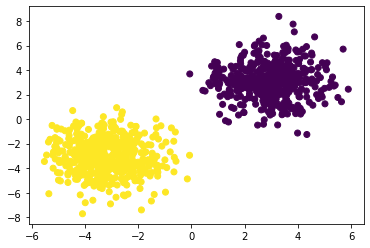

In [8]:
plt.scatter(x[:,0], x[:,1], c=y)

In [9]:
traj, losses = grad_descent(x, y, iterations=1500,learning_rate=1e-2)

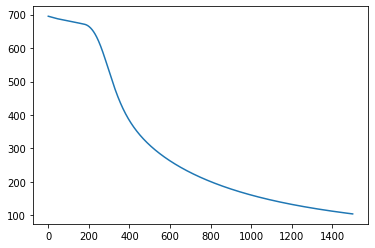

In [10]:
plt.plot(losses)


In [11]:
yhat(x[495:505],*pack_params(traj[-1]))

array([0.82486821, 0.82486821, 0.82486821, 0.82486821, 0.82486821,
       0.00122811, 0.0036247 , 0.03075248, 0.00091291, 0.04809235],
      dtype=float128)

In [12]:
y[495:505]

array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.])

In [13]:
sum(y == np.where(yhat(x,*pack_params(traj[-1])) > .5, 1, 0))

1000

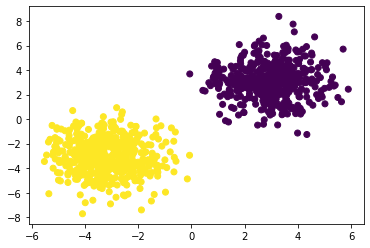

In [15]:
class_preds = (yhat(x,*pack_params(traj[-1])) > .5)*1
plt.scatter(x[:,0], x[:,1], c=class_preds)

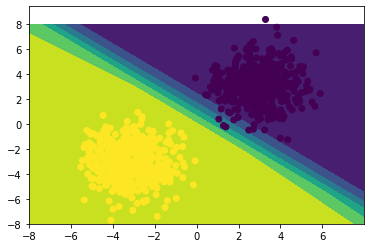

In [24]:
delta = 0.025
x1 = np.arange(-8.0, 8.0, delta)
x2 = np.arange(-8.0, 8.0, delta)
X1, X2 = np.meshgrid(x1, x2)
YHAT = yhat(np.array((X1.ravel(),X2.ravel())).T, *pack_params(traj[-1])).reshape((640,640))
fig, ax = plt.subplots()
CS = ax.contourf(X1, X2, YHAT)

plt.scatter(x[:,0], x[:,1], c=y)

## Scattered XOR dataset


In [ ]:
x = np.random.uniform(low=-2,high=2,size=1000).reshape((500,2))
y=np.zeros(500)
y[np.logical_and(x[:,0]>0 , x[:,1]>0)]=1
y[np.logical_and(x[:,0]<0 , x[:,1]<0)]=1

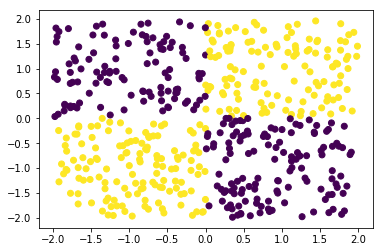

In [ ]:
plt.scatter(x[:,0],x[:,1],c=y)

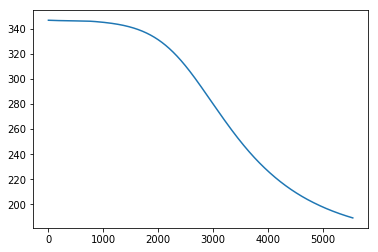

In [ ]:
traj, losses = grad_descent(x, y, iterations=5550,learning_rate=1e-2)
plt.plot(losses)

In [ ]:
sum(y == np.where(yhat(x,*pack_params(traj[-1])) > .5, 1, 0))

401

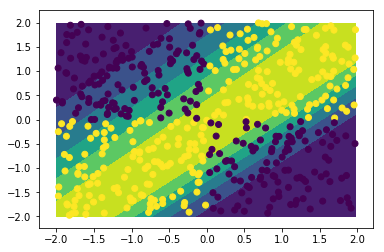

In [ ]:
delta = 0.025
x1 = np.arange(-2.0, 2.0, delta)
x2 = np.arange(-2.0, 2.0, delta)
X1, X2 = np.meshgrid(x1, x2)
YHAT = yhat(np.array((X1.ravel(),X2.ravel())).T, *pack_params(traj[-1])).reshape((160,160))
fig, ax = plt.subplots()
CS = ax.contourf(X1, X2, YHAT)

plt.scatter(x[:,0],x[:,1],c=y)

In [ ]:
yhat((2,-2), *pack_params(traj[-1]))

array([0.25817038], dtype=float128)

In [ ]:
YHAT

array([[0.9763842 , 0.97562122, 0.97483423, ..., 0.25817038, 0.25817038,
        0.25817038],
       [0.97564309, 0.97485679, 0.97404578, ..., 0.25817038, 0.25817038,
        0.25817038],
       [0.97487933, 0.97406902, 0.9732333 , ..., 0.25817038, 0.25817038,
        0.25817038],
       ...,
       [0.25817038, 0.25817038, 0.25817038, ..., 0.98323421, 0.9837971 ,
        0.98434139],
       [0.25817038, 0.25817038, 0.25817038, ..., 0.98383619, 0.98437919,
        0.98490423],
       [0.25817038, 0.25817038, 0.25817038, ..., 0.9844169 , 0.98494069,
        0.98544713]], dtype=float128)